<a href="https://colab.research.google.com/github/HirushikaPelagewtta/PR-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
from torchvision.datasets import EMNIST
import os

## Load the emnist dataset
Download and load the EMNIST dataset using torchvision's `datasets` module.


In [5]:
data_root = './data'
os.makedirs(data_root, exist_ok=True)

emnist_dataset = EMNIST(root=data_root, split='mnist', download=True)

### Visualize a few images


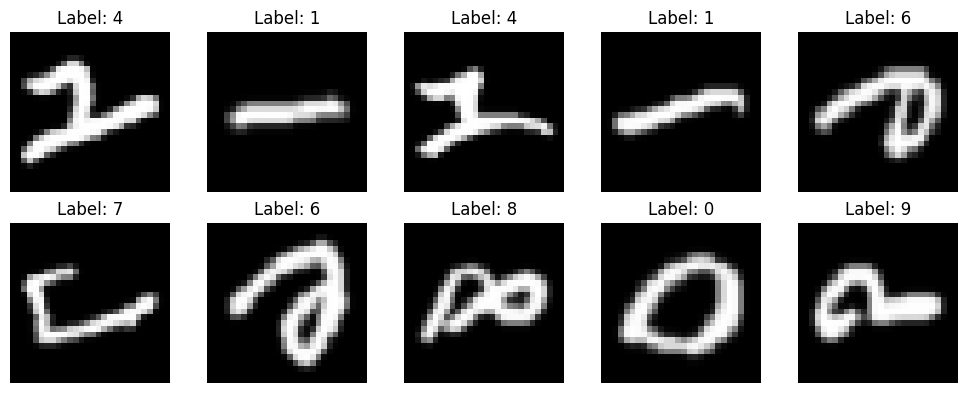

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i in range(10):
    img, label = emnist_dataset[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Dataset EMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [8]:
from torch.utils.data import random_split

# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Define the split ratios (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each split
total_samples = len(emnist_dataset)
train_samples = int(total_samples * train_ratio)
val_samples = int(total_samples * val_ratio)
test_samples = total_samples - train_samples - val_samples # Ensure all samples are included

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    emnist_dataset,
    [train_samples, val_samples, test_samples],
    generator=torch.Generator().manual_seed(seed) # Use the same seed for the generator
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 48000
Validation dataset size: 6000
Test dataset size: 6000
